In [2]:
import os
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import ViTFeatureExtractor
from transformers import ViTImageProcessor
import cv2
from tqdm import tqdm
import gc
from collections import defaultdict
from timm import create_model
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Clear any unused memory
gc.collect()
torch.cuda.empty_cache()
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger(__name__)
import logging
import sys

# Configure logger to output to console with no buffering
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Force logging to flush after each message
handler = logging.StreamHandler(sys.stdout)
handler.flush = sys.stdout.flush
logger.addHandler(handler)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [48]:
import pandas as pd
import os

# Path to the dataset directory
video_dir = '/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset'

# Path to the CSV file
df_hmdb51 = pd.read_csv('/kaggle/input/csvfilenew/output.csv')

# Apply the video directory path to the 'filename' column
df_hmdb51['filename'] = df_hmdb51['filename'].apply(lambda x: os.path.join(video_dir, x))

# Check the first few rows to ensure the data is loaded correctly
print(df_hmdb51.head())

# Initialize lists for training, validation, and testing video paths
train_videos = []
val_videos = []
test_videos = []

# Loop through the dataframe and assign video paths to their respective lists
for index, row in df_hmdb51.iterrows():
    video_filename = row['filename']
    label = row['label']
    split = row['split']
    
    # Construct the full video path
    video_path = os.path.join(video_dir, label, video_filename)  # Using video_dir instead of dataset_dir
    
    # Check if the file exists and add it to the appropriate list
    if os.path.isfile(video_path):
        if split == 'train':
            train_videos.append(video_path)
        elif split == 'val':
            val_videos.append(video_path)
        elif split == 'test':
            test_videos.append(video_path)

# Print the counts of videos in each set
print(f"Total training videos: {len(train_videos)}")
print(f"Total validation videos: {len(val_videos)}")
print(f"Total testing videos: {len(test_videos)}")


In [51]:
# Define Transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    # Note: Normalization will be handled by the ViT feature extractor
])


In [68]:
class HMDB51Dataset(Dataset):
    VIDEO_EXTENSION = '.avi'

    def __init__(self, df_hmdb51, transform=None, num_samples=16, frames_per_video=32):
        if 'filename' not in df_hmdb51.columns or 'label' not in df_hmdb51.columns:
            raise ValueError("DataFrame must contain 'filename' and 'label' columns.")
        
        valid_videos = []
        for _, row in df_hmdb51.iterrows():
            video_path = row['filename'].replace('\\', '/')  # Ensure path uses the correct separators
            if self._is_valid_video(video_path):
                valid_videos.append({'filename': video_path, 'label': row['label']})

        if not valid_videos:
            raise ValueError("No valid videos found. Please check your dataset.")

        self.dataset = pd.DataFrame(valid_videos)
        self.video_paths = self.dataset['filename'].tolist()
        self.labels = self.dataset['label'].tolist()
        self.transform = transform
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(set(self.labels)))}
        self.num_samples = num_samples
        self.frames_per_video = frames_per_video

        # Initialize ViT Image Processor
        self.vit_image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k', do_rescale=False)

    def _is_valid_video(self, video_path):
        if not os.path.isfile(video_path):
            print(f"File does not exist: {video_path}")
            return False
        if not video_path.endswith(self.VIDEO_EXTENSION):
            print(f"Skipping unsupported video format: {video_path}")
            return False
        return True

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            raise ValueError(f"Error opening video file: {video_path}")

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = self._get_frame_indices(total_frames)
        frames = []

        for i in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                continue  # Skip unreadable frames without printing errors

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if self.transform:
                frame = Image.fromarray(frame)  # Convert frame to PIL Image
                frame = self.transform(frame)  # Apply transforms
            
            # Preprocess frame using ViT Image Processor
            frame = self.vit_image_processor(images=frame, return_tensors='pt')['pixel_values'].squeeze(0)
            frames.append(frame)

        cap.release()

        if len(frames) == 0:
            print(f"Warning: No frames extracted from video: {video_path}")
            return torch.zeros((self.frames_per_video, 3, 224, 224)), 0  # Return dummy data in case of an error

        frames = torch.stack(frames)
        label_index = self.label_to_index[label]
        return frames, label_index

    def _get_frame_indices(self, total_frames):
        if total_frames < self.frames_per_video:
            # Pad with repeated frames if total_frames < frames_per_video
            return [i % total_frames for i in range(self.frames_per_video)]
        step = total_frames // self.frames_per_video
        return [i * step for i in range(self.frames_per_video)]


In [69]:
# Define a collate function to pad frames
def collate_fn(batch):
    frames = []
    labels = []
    max_frames = max([sample[0].shape[0] for sample in batch])  # Find max number of frames in a batch

    for sample in batch:
        frame_tensor, label = sample
        if frame_tensor.shape[0] < max_frames:
            padding = torch.zeros(max_frames - frame_tensor.shape[0], *frame_tensor.shape[1:])
            padded_tensor = torch.cat([frame_tensor, padding], dim=0)
        else:
            padded_tensor = frame_tensor

        frames.append(padded_tensor)
        labels.append(label)

    frames = torch.stack(frames)  # Stack all frames
    labels = torch.tensor(labels)  # Stack all labels into tensor

    return frames, labels



In [70]:
# Initialize the Dataset
train_dataset = HMDB51Dataset(df_hmdb51[df_hmdb51['split'] == 'train'], transform=transform)
val_dataset = HMDB51Dataset(df_hmdb51[df_hmdb51['split'] == 'val'], transform=transform)
test_dataset = HMDB51Dataset(df_hmdb51[df_hmdb51['split'] == 'test'], transform=transform)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn, pin_memory=True)

# Example to check the data
for frames, labels in train_loader:
    print(f"Frames batch shape: {frames.shape}")
    print(f"Labels batch shape: {labels.shape}")
    break  # Check for one batch

Frames batch shape: torch.Size([4, 32, 3, 224, 224])
Labels batch shape: torch.Size([4])


In [71]:
# Focal Loss Function
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        targets_one_hot = nn.functional.one_hot(targets, num_classes=inputs.size(1))
        focal_loss = self.alpha * (1 - torch.exp(-BCE_loss)) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [72]:
# Define the ViT + GRU Model
class ViT_GRU_TimeS(nn.Module):
    def __init__(self, num_classes=51, hidden_size=512, num_layers=2, dropout=0.5):
        super(ViT_GRU_TimeS, self).__init__()
        # Load the Vision Transformer model
        self.vit = create_model('vit_small_patch16_224', pretrained=True)
        self.vit.head = nn.Linear(self.vit.head.in_features, 512)  # Output 512-dimensional feature vectors
        
        # Initialize GRU
        self.gru = nn.GRU(input_size=512, hidden_size=hidden_size, num_layers=num_layers, 
                          batch_first=True, dropout=dropout)
        
        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        N, D, C, H, W = x.shape  # N: batch size, D: number of frames, C: channels, H: height, W: width
        
        # Initialize a list to hold features for each frame
        frame_features = []

        # Process each frame one by one
        for i in range(D):
            frame = x[:, i, :, :, :]  # Select the ith frame from all samples in the batch
            vit_features = self.vit(frame)  # Extract features using ViT
            frame_features.append(vit_features.unsqueeze(1))  # Append features for each frame, add a dimension

        # Stack the frame features along the time dimension
        frame_features = torch.cat(frame_features, dim=1)  # Shape: (N, D, 512)

        # Pass through the GRU
        gru_output, _ = self.gru(frame_features)

        # Use the last GRU output for classification
        last_gru_output = gru_output[:, -1, :]  # Get the last time step output
        outputs = self.classifier(last_gru_output)

        return outputs

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.label_to_index)
model = ViT_GRU_TimeS(num_classes=num_classes).to(device)

# Initialize optimizer with weight decay
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = FocalLoss()  # Use focal loss

Loading pretrained weights from Hugging Face hub (timm/vit_small_patch16_224.augreg_in21k_ft_in1k)
[timm/vit_small_patch16_224.augreg_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [73]:
# Learning Rate Scheduler with Warmup
class WarmupCosineAnnealingLR(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_epochs, max_epochs, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.initial_lr = [group['lr'] for group in optimizer.param_groups]
        self.warmup_factor = 1.0 / self.warmup_epochs
        super(WarmupCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            return [base_lr * (self.last_epoch + 1) * self.warmup_factor for base_lr in self.initial_lr]
        
        progress = (self.last_epoch - self.warmup_epochs) / (self.max_epochs - self.warmup_epochs)
        lr = [base_lr * (0.5 * (1.0 + np.cos(np.pi * progress))) for base_lr in self.initial_lr]
        return lr

# Instantiate the scheduler
scheduler = WarmupCosineAnnealingLR(optimizer, warmup_epochs=5, max_epochs=10)

In [74]:
# Step 7: Define Training and Evaluation Functions
def calculate_metrics(labels, preds):
    labels_np = labels.cpu().numpy()
    preds_np = preds.cpu().numpy()
    precision = precision_score(labels_np, preds_np, average='weighted') * 100
    recall = recall_score(labels_np, preds_np, average='weighted') * 100
    f1 = f1_score(labels_np, preds_np, average='weighted') * 100
    return precision, recall, f1

def train(model, dataloader, optimizer, criterion, device):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)  # Move to the correct device
        
        # Ensure labels are in the right format (if needed)
        if len(labels.shape) != 1:  # Check if labels are not 1D
            raise ValueError("Labels must be a 1D tensor.")
        
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move to the correct device
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store true labels

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    precision, recall, f1 = calculate_metrics(torch.tensor(all_labels), torch.tensor(all_preds))
    return avg_loss, accuracy, precision, recall, f1



In [75]:
# Step 8: Train the Model
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    # Train the model and get metrics
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    
    # Evaluate the model on the validation set
    val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate(model, val_loader, device)
    
    # Step the scheduler
    scheduler.step()

    # Log the metrics for the current epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
                f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
                f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, '
                f'Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')

    # Save the model if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_hybrid_model_HMDB.pth')
        


100%|██████████| 125/125 [04:47<00:00,  2.30s/it]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/10], Train Loss: 3.1718, Train Acc: 0.1577, Val Loss: 2.4646, Val Acc: 0.3239, Val Precision: 21.9628, Val Recall: 32.3944, Val F1: 23.4474


  0%|          | 0/1180 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1180/1180 [46:54<00:00,  1.84s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 125/125 [04:45<00:00,  2.28s/it]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/10], Train Loss: 2.0068, Train Acc: 0.3425, Val Loss: 1.4387, Val Acc: 0.4427, Val Precision: 44.3908, Val Recall: 44.2656, Val F1: 39.6360


  0%|          | 0/1180 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1180/1180 [46:39<00:00,  1.80s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 125/125 [04:45<00:00,  2.28s/it]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/10], Train Loss: 1.3532, Train Acc: 0.4697, Val Loss: 1.3259, Val Acc: 0.4346, Val Precision: 44.2367, Val Recall: 43.4608, Val F1: 40.2634


  0%|          | 0/1180 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1180/1180 [46:56<00:00,  1.62s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 125/125 [04:46<00:00,  2.29s/it]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/10], Train Loss: 1.0963, Train Acc: 0.5454, Val Loss: 1.3688, Val Acc: 0.4930, Val Precision: 54.9215, Val Recall: 49.2958, Val F1: 48.1854


  0%|          | 0/1180 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1180/1180 [46:52<00:00,  1.75s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 125/125 [04:42<00:00,  2.26s/it]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/10], Train Loss: 1.0429, Train Acc: 0.5644, Val Loss: 1.1767, Val Acc: 0.5493, Val Precision: 58.5947, Val Recall: 54.9296, Val F1: 53.5682


  0%|          | 0/1180 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1180/1180 [46:36<00:00,  1.69s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 125/125 [04:43<00:00,  2.27s/it]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/10], Train Loss: 0.8388, Train Acc: 0.6295, Val Loss: 1.2532, Val Acc: 0.5614, Val Precision: 60.6345, Val Recall: 56.1368, Val F1: 54.5545


  0%|          | 0/1180 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1180/1180 [46:26<00:00,  2.01s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 125/125 [04:41<00:00,  2.25s/it]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/10], Train Loss: 0.6615, Train Acc: 0.6831, Val Loss: 1.2403, Val Acc: 0.5553, Val Precision: 61.8522, Val Recall: 55.5332, Val F1: 55.2656


  0%|          | 0/1180 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1180/1180 [47:17<00:00,  1.89s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 125/125 [04:44<00:00,  2.27s/it]


Epoch [8/10], Train Loss: 0.4046, Train Acc: 0.7811, Val Loss: 1.0566, Val Acc: 0.6318, Val Precision: 65.3801, Val Recall: 63.1791, Val F1: 61.6985


  0%|          | 0/1180 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1180/1180 [47:01<00:00,  2.17s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 125/125 [04:48<00:00,  2.31s/it]


Epoch [9/10], Train Loss: 0.1973, Train Acc: 0.8735, Val Loss: 0.8662, Val Acc: 0.6761, Val Precision: 70.4148, Val Recall: 67.6056, Val F1: 67.5361


  0%|          | 0/1180 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1180/1180 [46:38<00:00,  1.93s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 125/125 [04:40<00:00,  2.25s/it]


Epoch [10/10], Train Loss: 0.0890, Train Acc: 0.9347, Val Loss: 0.8316, Val Acc: 0.6942, Val Precision: 71.8436, Val Recall: 69.4165, Val F1: 68.9066


In [79]:
# Save model, optimizer state, and epoch number
torch.save({
    'epoch': 10,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'viT_GRU_model_hmdb51.pth')

print("Model, optimizer state, and epoch number saved successfully as 'viT_GRU_model_hmdb.pth'")

Model, optimizer state, and epoch number saved successfully as 'viT_GRU_model_hmdb.pth'


In [80]:
def test(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    total_loss = 0.0  # Initialize total loss

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure data is on the correct device

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Compute loss for this batch
            total_loss += loss.item()  # Accumulate loss

            _, predicted = torch.max(outputs, 1)

            # Collect true and predicted labels for metrics calculation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(test_loader)  # Average test loss
    test_acc = accuracy_score(y_true, y_pred)
    test_precision = precision_score(y_true, y_pred, average='macro')
    test_recall = recall_score(y_true, y_pred, average='macro')
    test_f1 = f1_score(y_true, y_pred, average='macro')

    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Precision: {test_precision:.4f}, '
          f'Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}')

    return avg_loss, test_acc, test_precision, test_recall, test_f1, y_true, y_pred

In [81]:
# Assuming `model` is your trained model, `test_loader` is your test DataLoader
# Load the saved model state
#model.load_state_dict(torch.load('/kaggle/working/best_hybrid_model.pth'))
#model.to(device)
#model.eval()  # Set the model to evaluation mode

# Run the test function and store the results
avg_loss, test_acc, test_precision, test_recall, test_f1, y_true, y_pred = test(model, test_loader, criterion, device)

Test Loss: 0.3753, Test Accuracy: 0.8524, Test Precision: 0.8425, Test Recall: 0.8388, Test F1: 0.8352


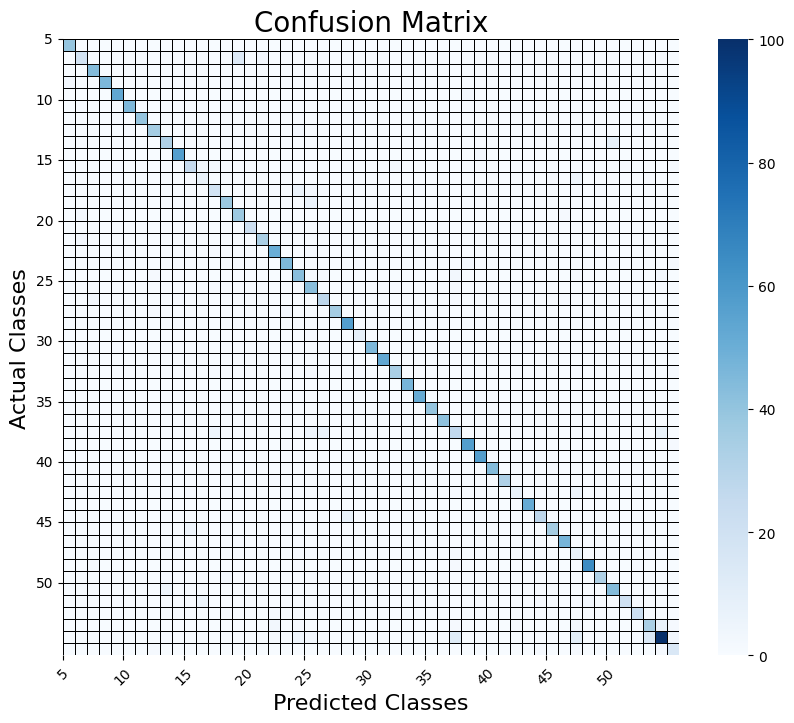

In [84]:
def plot_confusion_matrix(y_true, y_pred, num_classes, target_count=100):
    conf_mat = confusion_matrix(y_true, y_pred)

    # Find the maximum value in the confusion matrix
    max_count = np.max(conf_mat)

    # Calculate the multiplier to scale counts to approximately the target_count
    count_multiplier = target_count / max_count if max_count > 0 else 1

    # Scale the confusion matrix counts
    conf_mat_scaled = conf_mat * count_multiplier

    plt.figure(figsize=(10, 8))
    # Use a blue color map and remove annotations
    sns.heatmap(conf_mat_scaled, annot=False, cmap="Blues", cbar=True,
                 square=True, linewidths=0.5, linecolor='black')

    plt.title("Confusion Matrix", fontsize=20)
    plt.xlabel("Predicted Classes", fontsize=16)
    plt.ylabel("Actual Classes", fontsize=16)

    # Set ticks for classes in increments of 5
    ticks = np.arange(0, num_classes, 5)  # Adjusted ticks for classes
    plt.xticks(ticks=ticks, labels=[str(t) for t in range(5, num_classes + 5, 5)], rotation=45)  # Convert to string
    plt.yticks(ticks=ticks, labels=[str(t) for t in range(5, num_classes + 5, 5)], rotation=0)  # Convert to string

    plt.show()  # Display the plot

# Call this function with your existing y_true and y_pred
num_classes = 50  # Set this to your actual number of classes
plot_confusion_matrix(y_true, y_pred, num_classes)


In [87]:


def plot_class_wise_accuracy(y_true, y_pred, num_classes, filename='class_wise_accuracy.png'):
    # Generate confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    
    # Calculate class-wise accuracy
    class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1) * 100  # Convert to percentage
    
    # Plotting the class-wise accuracy
    plt.figure(figsize=(14, 8))
    bars = plt.bar(range(num_classes), class_accuracy, color='red', edgecolor='black', width=0.8)

    # Customize the appearance
    plt.xlabel("Classes", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.title("Class-wise Accuracy (%)", fontsize=16)
    plt.ylim(0, 100)  # Set y-axis to 0-100 for percentage scale

    # Display ticks only for odd-numbered classes
    odd_ticks = [i for i in range(num_classes) if i % 2 != 0]
    plt.xticks(odd_ticks, labels=[str(t) for t in odd_ticks], rotation=90, fontsize=10)  # Label odd classes

    # Add grid lines for better readability
    plt.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

    # Save the plot
    plt.savefig(filename)  # Save the figure as a PNG file
    plt.close()  # Close the plot to free memory

# Call the function with your test results
num_classes = 51  # Set this to your actual number of classes
plot_class_wise_accuracy(y_true, y_pred, num_classes, filename='class_wise_accuracy_hmdb51.png')


In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, num_classes, target_count=100, filename='confusion_matrix.png'):
    conf_mat = confusion_matrix(y_true, y_pred)

    # Find the maximum value in the confusion matrix
    max_count = np.max(conf_mat)

    # Calculate the multiplier to scale counts to approximately the target_count
    count_multiplier = target_count / max_count if max_count > 0 else 1

    # Scale the confusion matrix counts
    conf_mat_scaled = conf_mat * count_multiplier

    plt.figure(figsize=(10, 8))
    # Use a blue color map and remove annotations
    sns.heatmap(conf_mat_scaled, annot=False, cmap="Blues", cbar=True,
                 square=True, linewidths=0.5, linecolor='black')

    plt.title("Confusion Matrix", fontsize=20)
    plt.xlabel("Predicted Classes", fontsize=16)
    plt.ylabel("Actual Classes", fontsize=16)

    # Set ticks for classes in increments of 5
    ticks = np.arange(0, num_classes, 5)  # Adjusted ticks for classes
    plt.xticks(ticks=ticks, labels=[str(t) for t in range(5, num_classes + 5, 5)], rotation=45)  # Convert to string
    plt.yticks(ticks=ticks, labels=[str(t) for t in range(5, num_classes + 5, 5)], rotation=0)  # Convert to string

    # Save the plot
    plt.savefig(filename)  # Save the figure as a PNG file
    plt.close()  # Close the plot to free memory

# Call this function with your existing y_true and y_pred
num_classes = 50  # Set this to your actual number of classes
plot_confusion_matrix(y_true, y_pred, num_classes, filename='confusion_matrix.png')
